## 5.2-5.4 Realistic Synthetic Spectra

In [1]:
import numpy as np
import pylab as plt
import utils
from scipy.optimize import minimize

c = 299792458. # m/s
np.random.seed(1)
sqrttwopi = np.sqrt(2. * np.pi)

Generate the data:

In [2]:
fwhms = np.asarray([0.1077, 0.1113]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([5000.206, 5000.348]) # line center (A)
cs = np.asarray([-0.113524, -0.533461]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.03 # A
xs = np.arange(4999.4 + 0.5 * dx, 5001.1, dx) # A
snr = 100.

N = 64
data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)

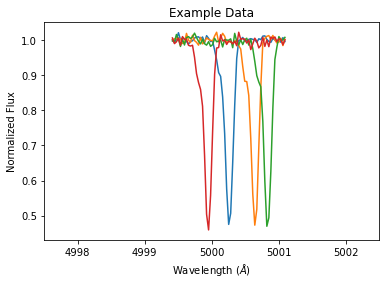

In [3]:
for n in range(0,N,20):
    plt.plot(xs, data[n])
plt.xlim([4997.5,5002.5])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux');

Calculate CRLB:

In [4]:
crlb = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
print("CRLB:", crlb, "m/s")

CRLB: 49.21189180873227 m/s


# 5.2 Binary mask x-correlation

Let's start by using the binary mask supplied in [the Ceres pipeline](https://github.com/rabrahm/ceres) ([Brahm et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017PASP..129c4002B/abstract)), which claims to reproduce the capabilities of the (proprietary) HARPS instrument pipeline's binary mask. This should yield realistic results for a typical binary-mask-based data reduction.

In [5]:
mask_data = utils.load_mask(4998., 5002.)
(mask_ws, mask_ms, mask_hws) = mask_data # unpack

In [6]:
guess_rvs = true_rvs + np.random.normal(0., 10., size=N) # first-guess RVs
rvs_0 = utils.solve_for_rvs('binary_mask', guess_rvs, 
                            xs, data, ivars, dx, 
                            mask_data=mask_data,
                            grid_hw=1.5e4, max_method='gaussian')

100%|██████████| 64/64 [00:18<00:00,  3.38it/s]


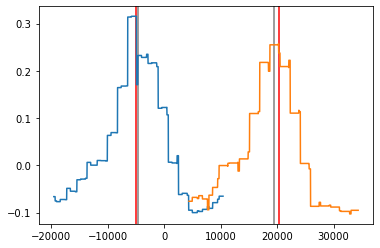

In [7]:
args = (xs, mask_ws, mask_ms, 0.5 * dx, mask_hws)
func = utils.make_mask
for n in [0,20]:
    rvs, objs = utils.get_objective_on_grid(data[n], ivars[n], func, args, 
                                            rvs_0[n], 1.5e4)
    plt.axvline(utils.quadratic_max(rvs, objs), color='r')
    plt.axvline(utils.gaussian_max(rvs, objs, verbose=False), color='k', alpha=0.5)
    plt.plot(rvs, objs)
    '''
    guess_par = (rvs_0[n], 5.e3,
                (max(objs)-min(objs)) * 5.e3 * sqrttwopi,
                min(objs)) # mean, sigma, amplitude, offset
    (mm, sig, amp, offs) = minimize(utils.gaussian_resid, guess_par, args=(rvs, objs))['x']
    objs_g = amp * utils.oned_gaussian(rvs, mm, sig) + offs
    plt.plot(rvs, objs_g, ls='--', c='k', alpha=0.6)
    '''

RV RMS: 373.2120 m/s
performing with 658% higher uncertainty than the CRLB


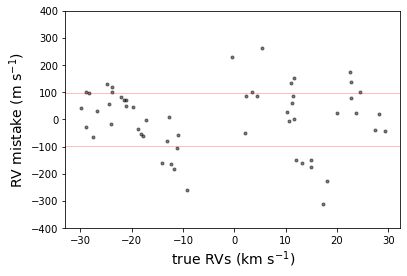

In [8]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)", fontsize=14)
plt.ylabel(r"RV mistake (m s$^{-1}$)", fontsize=14)
print("RV RMS: {0:.4f} m/s".format(np.std(resid)))
print("performing with {0:.0f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

So the binary mask can saturate the CRLB! Note that this is true if & only if none of the selected lines come on & off the observed wavelength grid throughout the year. If we adjust the test case to have less padding at the edges, e.g. trim `xs` down by 0.5 A at either end, then we will get correlated noise in the RV residuals due to the highly asymmetric CCFs.

What if the mask we use is slightly wrong?

# 5.3 Rigid Template

How about if we cross-correlate with a stellar spectrum? In these examples we will use a rigid template (i.e. a template spectrum that does not get adjusted during subsequent iterations). One example template would be a single, high-SNR observation of the target star - this is a typical strategy employed with iodine-cell-using instruments.

In [9]:
template_xs = np.arange(4997. + 0.5 * dx, 5003., dx) # A
template_ys = utils.make_synth(0.0, template_xs, ds, ms, sigs)
template_ys += np.random.normal(size=len(template_xs)) / 300. # SNR = 300

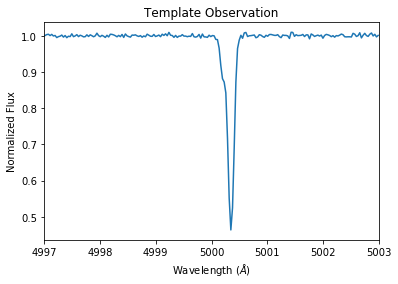

In [10]:
plt.plot(template_xs, template_ys)
plt.xlim([4997.,5003.])
plt.title('Template Observation')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux');

In [11]:
rvs_0 = utils.solve_for_rvs('rigid_template', guess_rvs, xs, data, ivars, dx, 
                            template_data=(template_xs, template_ys))

100%|██████████| 64/64 [00:03<00:00, 16.10it/s]


RV RMS: 52.2467 m/s
performing with 6% higher uncertainty than the CRLB


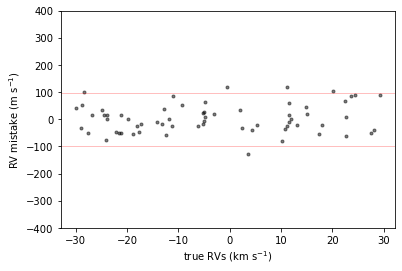

In [12]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print("RV RMS: {0:.4f} m/s".format(np.std(resid)))
print("performing with {0:.0f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

The above example performs well, but we cheated a little bit by expanding the wavelength range of the template beyond that of the other spectra. This is because otherwise at certain barycentric RV shifts, the cross-correlation is prone to mis-matching the lines. We're also assuming that the template observation was taken under exactly identical conditions to the time-series RV spectra, which may not necessarily be the case if the instrument is changing over long timescales.

Also note that if we degrade the template spectrum to a lower SNR, the performance quickly becomes much worse.

## 5.4 Data-driven Template

We can do better than a single observation as a template. Let's try shifting & stacking all the observations to generate a template from *all* the available data.

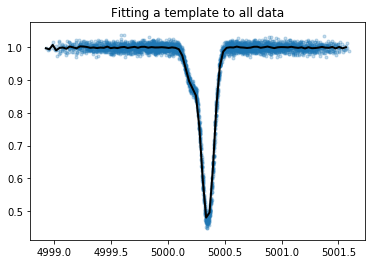

In [13]:
template_xs, template_ys = utils.make_template(data, guess_rvs, xs, dx, plot=True)

In [14]:
rvs_0 = utils.solve_for_rvs('rigid_template', guess_rvs, xs, data, ivars, dx, 
                            template_data=(template_xs, template_ys))

100%|██████████| 64/64 [00:03<00:00, 16.28it/s]


RV RMS: 50.5415 m/s
performing with 3% higher uncertainty than the CRLB


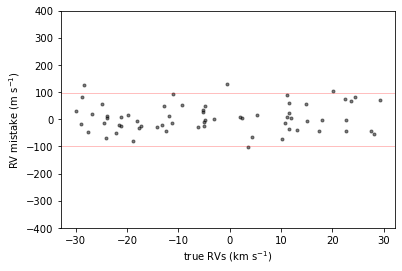

In [15]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print("RV RMS: {0:.4f} m/s".format(np.std(resid)))
print("performing with {0:.0f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

Let's try implementing a simple version of *wobble* to simulataneously solve for the template fluxes and RVs! Note that this will entail a *lot* of free parameters (500 template pixels + 64 RVs), unlike the previous model which treated `template_ys` as a function of the data and had to optimize only the RVs.

In [16]:
rvs_factor = 1.e3 # HACK to scale RVs to vary at a similar %age to template_ys

def unpack_par(par, N):
    rvs = par[:N] * rvs_factor
    template_ys = par[N:]
    return rvs, template_ys

def pack_par(rvs, template_ys):
    return np.append(rvs/rvs_factor, template_ys)

def model(par, template_xs, data_xs, M, N):
    rvs, template_ys = unpack_par(par, N)
    model = np.zeros((N,M))
    for n in range(N):
        model[n,:] = utils.shift_template(rvs[n], data_xs, template_xs, template_ys)
    return model

def chisq(guess, data_ys, ivars):
    return np.sum((data_ys - guess)**2 * ivars)

def minimize_me(par, template_xs, data_xs, data_ys, ivars):
    N,M = np.shape(data_ys)
    guess = model(par, template_xs, data_xs, M, N)
    return chisq(guess, data_ys, ivars)

In [17]:
par0 = pack_par(rvs_0, template_ys)
print('chisq at initial guess: {0:.1f}'.format(minimize_me(par0, template_xs, xs, data, ivars)))

chisq at initial guess: 4059.7


In [18]:
%%time
soln = minimize(minimize_me, par0, args=(template_xs, xs, data, ivars))
print('chisq at final answer: {0:.1f}'.format(minimize_me(soln['x'], template_xs, xs, data, ivars)))

chisq at final answer: 3575.2
CPU times: user 3min 25s, sys: 6.9 s, total: 3min 32s
Wall time: 2min 41s


RV RMS: 52.2047 m/s
performing with 6% higher uncertainty than the CRLB


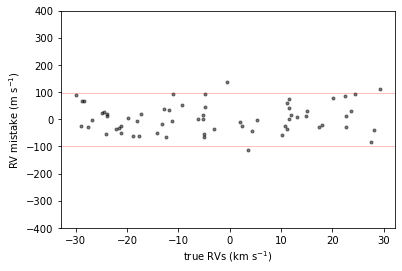

In [19]:
rvs_opt, template_ys_opt = unpack_par(soln['x'], N)
resid = rvs_opt - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print("RV RMS: {0:.4f} m/s".format(np.std(resid)))
print("performing with {0:.0f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

In [20]:
import wobble
wobble_data = wobble.Data()
for n in range(N):
    sp = wobble.Spectrum([xs], [data[n]], [ivars[n]], bervs=-1.*rvs_0[n], airms=1.0)
    sp.transform_log()
    wobble_data.append(sp)

/Users/mbedell/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mbedell/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mbedell/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mbedell/miniconda3/lib/python3.6/site-packages/tensorflow/python/f

In [66]:
results = wobble.Results(data=wobble_data)
wobble_model = wobble.Model(wobble_data, results, 0)
wobble_model.add_star('star1', regularization_par_file=None, template_xs=np.log(template_xs), template_ys=np.log(template_ys))
wobble_model.setup()

In [67]:
%%time
wobble_model.optimize(niter=200)

100%|██████████| 200/200 [00:00<00:00, 1107.43it/s]

optimize: iterating through 200 optimization steps...



100%|██████████| 64/64 [00:00<00:00, 470.85it/s]


optimize: calculating uncertainties on star1 rvs...
CPU times: user 639 ms, sys: 93.3 ms, total: 732 ms
Wall time: 435 ms


RV RMS: 50.5899 m/s
performing with 3% higher uncertainty than the CRLB


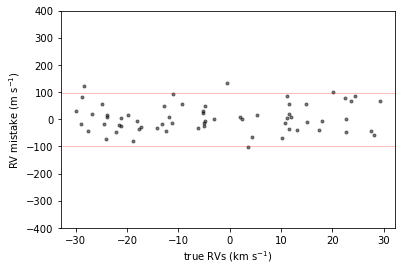

In [68]:
rvs_opt = results.star1_rvs[0]
resid = rvs_opt - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print("RV RMS: {0:.4f} m/s".format(np.std(resid)))
print("performing with {0:.0f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

In [69]:
pars_wobble = pack_par(results.star1_rvs[0], np.exp(results.star1_template_ys[0]))
print('chisq from wobble optimization: {0:.1f}'.format(minimize_me(pars_wobble, np.exp(results.star1_template_xs[0]), xs, data, ivars)))

chisq from wobble optimization: 3670.8


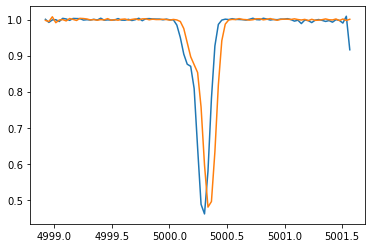

In [55]:
plt.plot(np.exp(results.star1_template_xs[0]), np.exp(results.star1_template_ys[0]))
plt.plot(template_xs, template_ys);

*Question:* why is the chi-squared larger after doing the wobble optimization? Particularly if the RVs are better?